In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from scipy.special import expit
import torch
from torch import nn, optim
import torch.nn.functional as F
from datasets import get_wine_dataloader
from sklearn.manifold import TSNE

device = torch.device("cpu")

# Wine
n_clusters = 3
batch_size = 89
dataloader, data_shape = get_wine_dataloader(batch_size)
N = len(dataloader) * batch_size

In [2]:
k1 = 10
k2 = 30
latent_shape = 5

class Autoencoder(nn.Module):
    def __init__(self, n_features):
        super(Autoencoder, self).__init__()
        # Encoder Model
        self.encoder_model = nn.Sequential(
            nn.Linear(data_shape, k1, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(k1),
            
            nn.Linear(k1, k2, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(k2),
            
            nn.Linear(k2, latent_shape, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(latent_shape),
            
            #nn.Linear(k3, k4, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(k4),
        )
        
        # Clustering MLP
        self.cluster_MLP = nn.Sequential(
            #nn.Linear(latent_shape, k1, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(k1),
            
            nn.Linear(latent_shape, n_clusters, bias=True),
            nn.BatchNorm1d(n_clusters)
        )
        
        # Decoder Model
        self.decoder_model = nn.Sequential(
            #nn.Linear(k4, k3, bias=True),
            #nn.ReLU(inplace=True),
            #nn.BatchNorm1d(k3),
            
            nn.Linear(latent_shape, k2, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(k2),
            
            nn.Linear(k2, k1, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(k1),
            
            nn.Linear(k1, data_shape, bias=True),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.encoder_model(x)
        x = self.decoder_model(x)
        return x

    def forward_softMin(self, x):
        x = self.encoder_model(x)
        x = self.cluster_MLP(x)
        x = F.softmin(x, dim=1)
        return x
    
    def encoder(self, x):
        x = self.encoder_model(x)
        return x
    
    def decoder(self, x):
        x = self.decoder_model(x)
        return x

autoencoder = Autoencoder(100)
autoencoder = autoencoder.to(device)

In [3]:
def soft_silhouette(X, soft_clustering, requires_distance_grad=False):
    # No grads at distances
    if requires_distance_grad: X = X.detach()
    distances = torch.cdist(X, X, p=2)
    alphas = torch.matmul(distances, soft_clustering)
    n_data, n_clusters = alphas.shape
    betas = torch.empty(alphas.shape)
    
    for i in range(n_data):
        for j in range(n_clusters):
            betas[i][j] = min([alphas[i][x] for x in range(alphas.shape[1]) if x!=j])
    
    # Calculate soft silhouette
    sc = torch.div(torch.sub(betas, alphas), torch.max(alphas, betas))
    s = torch.mean(torch.sum(torch.mul(soft_clustering, sc), dim=1))

    return s

def transform_clusters_to_labels(clusters, labels):
    # Get the data clusters based on max neuron
    clusters = torch.argmax(clusters, dim=1)
    clusters = clusters.cpu().detach().numpy()

    # Find the cluster ids (labels)
    c_ids = np.unique(clusters)
    labels = labels.cpu().data.numpy()

    # Dictionary to transform cluster label to real label
    dict_clusters_to_labels = dict()
    
    # For every cluster find the most frequent data label
    for c_id in c_ids:
        indexes_of_cluster_i = np.where(c_id == clusters)
        elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
        true_label_index = np.argmax(frequency)
        true_label = elements[true_label_index]
        dict_clusters_to_labels[c_id] = true_label

    # Change the cluster labels to real labels
    for i, element in enumerate(clusters):
        clusters[i] = dict_clusters_to_labels[element]

    return clusters

In [4]:
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
mse = nn.MSELoss()

for epoch in range(1000):
    for batch_index, (real_data, labels) in enumerate(dataloader):
        reconstruction = autoencoder.forward(real_data)
        loss = mse(real_data, reconstruction)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("Epoch: {} Rec: {:.4f} ".format(epoch, loss))

Epoch: 0 Rec: 0.1864 
Epoch: 1 Rec: 0.1404 
Epoch: 2 Rec: 0.1268 
Epoch: 3 Rec: 0.1145 
Epoch: 4 Rec: 0.1046 
Epoch: 5 Rec: 0.0971 
Epoch: 6 Rec: 0.0878 
Epoch: 7 Rec: 0.0777 
Epoch: 8 Rec: 0.0701 
Epoch: 9 Rec: 0.0670 
Epoch: 10 Rec: 0.0658 
Epoch: 11 Rec: 0.0631 
Epoch: 12 Rec: 0.0602 
Epoch: 13 Rec: 0.0574 
Epoch: 14 Rec: 0.0552 
Epoch: 15 Rec: 0.0525 
Epoch: 16 Rec: 0.0501 
Epoch: 17 Rec: 0.0472 
Epoch: 18 Rec: 0.0440 
Epoch: 19 Rec: 0.0417 
Epoch: 20 Rec: 0.0403 
Epoch: 21 Rec: 0.0389 
Epoch: 22 Rec: 0.0375 
Epoch: 23 Rec: 0.0366 
Epoch: 24 Rec: 0.0360 
Epoch: 25 Rec: 0.0351 
Epoch: 26 Rec: 0.0347 
Epoch: 27 Rec: 0.0345 
Epoch: 28 Rec: 0.0339 
Epoch: 29 Rec: 0.0336 
Epoch: 30 Rec: 0.0333 
Epoch: 31 Rec: 0.0331 
Epoch: 32 Rec: 0.0328 
Epoch: 33 Rec: 0.0326 
Epoch: 34 Rec: 0.0323 
Epoch: 35 Rec: 0.0321 
Epoch: 36 Rec: 0.0318 
Epoch: 37 Rec: 0.0316 
Epoch: 38 Rec: 0.0313 
Epoch: 39 Rec: 0.0310 
Epoch: 40 Rec: 0.0308 
Epoch: 41 Rec: 0.0306 
Epoch: 42 Rec: 0.0304 
Epoch: 43 Rec: 0.0302

Epoch: 365 Rec: 0.0078 
Epoch: 366 Rec: 0.0077 
Epoch: 367 Rec: 0.0076 
Epoch: 368 Rec: 0.0076 
Epoch: 369 Rec: 0.0076 
Epoch: 370 Rec: 0.0076 
Epoch: 371 Rec: 0.0076 
Epoch: 372 Rec: 0.0075 
Epoch: 373 Rec: 0.0074 
Epoch: 374 Rec: 0.0075 
Epoch: 375 Rec: 0.0075 
Epoch: 376 Rec: 0.0075 
Epoch: 377 Rec: 0.0075 
Epoch: 378 Rec: 0.0076 
Epoch: 379 Rec: 0.0076 
Epoch: 380 Rec: 0.0076 
Epoch: 381 Rec: 0.0075 
Epoch: 382 Rec: 0.0074 
Epoch: 383 Rec: 0.0074 
Epoch: 384 Rec: 0.0074 
Epoch: 385 Rec: 0.0076 
Epoch: 386 Rec: 0.0077 
Epoch: 387 Rec: 0.0078 
Epoch: 388 Rec: 0.0079 
Epoch: 389 Rec: 0.0080 
Epoch: 390 Rec: 0.0078 
Epoch: 391 Rec: 0.0075 
Epoch: 392 Rec: 0.0074 
Epoch: 393 Rec: 0.0075 
Epoch: 394 Rec: 0.0076 
Epoch: 395 Rec: 0.0076 
Epoch: 396 Rec: 0.0074 
Epoch: 397 Rec: 0.0073 
Epoch: 398 Rec: 0.0074 
Epoch: 399 Rec: 0.0074 
Epoch: 400 Rec: 0.0074 
Epoch: 401 Rec: 0.0074 
Epoch: 402 Rec: 0.0074 
Epoch: 403 Rec: 0.0073 
Epoch: 404 Rec: 0.0074 
Epoch: 405 Rec: 0.0074 
Epoch: 406 Rec: 

Epoch: 724 Rec: 0.0062 
Epoch: 725 Rec: 0.0063 
Epoch: 726 Rec: 0.0063 
Epoch: 727 Rec: 0.0063 
Epoch: 728 Rec: 0.0064 
Epoch: 729 Rec: 0.0063 
Epoch: 730 Rec: 0.0062 
Epoch: 731 Rec: 0.0062 
Epoch: 732 Rec: 0.0062 
Epoch: 733 Rec: 0.0062 
Epoch: 734 Rec: 0.0062 
Epoch: 735 Rec: 0.0062 
Epoch: 736 Rec: 0.0063 
Epoch: 737 Rec: 0.0066 
Epoch: 738 Rec: 0.0067 
Epoch: 739 Rec: 0.0066 
Epoch: 740 Rec: 0.0066 
Epoch: 741 Rec: 0.0066 
Epoch: 742 Rec: 0.0066 
Epoch: 743 Rec: 0.0065 
Epoch: 744 Rec: 0.0063 
Epoch: 745 Rec: 0.0064 
Epoch: 746 Rec: 0.0065 
Epoch: 747 Rec: 0.0065 
Epoch: 748 Rec: 0.0065 
Epoch: 749 Rec: 0.0065 
Epoch: 750 Rec: 0.0063 
Epoch: 751 Rec: 0.0062 
Epoch: 752 Rec: 0.0062 
Epoch: 753 Rec: 0.0061 
Epoch: 754 Rec: 0.0062 
Epoch: 755 Rec: 0.0063 
Epoch: 756 Rec: 0.0062 
Epoch: 757 Rec: 0.0063 
Epoch: 758 Rec: 0.0063 
Epoch: 759 Rec: 0.0063 
Epoch: 760 Rec: 0.0062 
Epoch: 761 Rec: 0.0063 
Epoch: 762 Rec: 0.0061 
Epoch: 763 Rec: 0.0061 
Epoch: 764 Rec: 0.0061 
Epoch: 765 Rec: 

In [5]:
lamda = 100
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
mse = nn.MSELoss()

latent_data = np.zeros((N, latent_shape))
real_labels = np.zeros((N), dtype=np.int32)
predicted_labels = np.zeros((N), dtype=np.int32)

for epoch in range(300):
    sum_rec_loss = 0
    sum_soft_sihouette = 0
    for batch_index, (real_data, labels) in enumerate(dataloader):
        reconstruction = autoencoder.forward(real_data)
        soft_clustering = autoencoder.forward_softMin(real_data)
        code = autoencoder.encoder(real_data)
        s = soft_silhouette(code, soft_clustering)
        rec = mse(reconstruction, real_data)
        loss = 1 - s + lamda * rec
        
        sum_rec_loss += rec.item()
        sum_soft_sihouette += s.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Selecting the nearest samples and save their priors
        lower = batch_index * batch_size
        upper = (batch_index + 1) * batch_size
        latent_data[lower:upper] = code.cpu().detach().numpy()
        real_labels[lower:upper] = labels.cpu().data.numpy()
        predicted_labels[lower:upper] = transform_clusters_to_labels(soft_clustering, labels)
    
    accuracy = accuracy_score(real_labels, predicted_labels)
    nmi = normalized_mutual_info_score(real_labels, predicted_labels)
    total_loss = sum_rec_loss + sum_soft_sihouette
    print("Epoch: {} L: {:.4f} Rec: {:.4f} Soft SIL: {:.2f} ACC: {:.2f} NMI: {:.2f} ".format(epoch, total_loss, sum_rec_loss, sum_soft_sihouette, accuracy, nmi))

Epoch: 0 L: 0.0430 Rec: 0.0305 Soft SIL: 0.01 ACC: 0.56 NMI: 0.26 
Epoch: 1 L: 0.0771 Rec: 0.0243 Soft SIL: 0.05 ACC: 0.77 NMI: 0.45 
Epoch: 2 L: 0.1221 Rec: 0.0238 Soft SIL: 0.10 ACC: 0.78 NMI: 0.48 
Epoch: 3 L: 0.1678 Rec: 0.0205 Soft SIL: 0.15 ACC: 0.81 NMI: 0.54 
Epoch: 4 L: 0.2274 Rec: 0.0209 Soft SIL: 0.21 ACC: 0.84 NMI: 0.57 
Epoch: 5 L: 0.3020 Rec: 0.0191 Soft SIL: 0.28 ACC: 0.86 NMI: 0.62 
Epoch: 6 L: 0.3835 Rec: 0.0185 Soft SIL: 0.37 ACC: 0.89 NMI: 0.67 
Epoch: 7 L: 0.4460 Rec: 0.0184 Soft SIL: 0.43 ACC: 0.92 NMI: 0.73 
Epoch: 8 L: 0.4873 Rec: 0.0172 Soft SIL: 0.47 ACC: 0.93 NMI: 0.77 
Epoch: 9 L: 0.5147 Rec: 0.0166 Soft SIL: 0.50 ACC: 0.94 NMI: 0.80 
Epoch: 10 L: 0.5375 Rec: 0.0164 Soft SIL: 0.52 ACC: 0.94 NMI: 0.80 
Epoch: 11 L: 0.5635 Rec: 0.0161 Soft SIL: 0.55 ACC: 0.94 NMI: 0.80 
Epoch: 12 L: 0.5897 Rec: 0.0159 Soft SIL: 0.57 ACC: 0.94 NMI: 0.81 
Epoch: 13 L: 0.6141 Rec: 0.0155 Soft SIL: 0.60 ACC: 0.94 NMI: 0.81 
Epoch: 14 L: 0.6392 Rec: 0.0154 Soft SIL: 0.62 ACC: 0.94 N

Epoch: 121 L: 1.6006 Rec: 0.0136 Soft SIL: 1.59 ACC: 0.97 NMI: 0.88 
Epoch: 122 L: 1.6014 Rec: 0.0135 Soft SIL: 1.59 ACC: 0.97 NMI: 0.88 
Epoch: 123 L: 1.6000 Rec: 0.0137 Soft SIL: 1.59 ACC: 0.97 NMI: 0.88 
Epoch: 124 L: 1.6002 Rec: 0.0138 Soft SIL: 1.59 ACC: 0.97 NMI: 0.88 
Epoch: 125 L: 1.6009 Rec: 0.0133 Soft SIL: 1.59 ACC: 0.97 NMI: 0.88 
Epoch: 126 L: 1.6025 Rec: 0.0133 Soft SIL: 1.59 ACC: 0.97 NMI: 0.88 
Epoch: 127 L: 1.6090 Rec: 0.0132 Soft SIL: 1.60 ACC: 0.97 NMI: 0.88 
Epoch: 128 L: 1.6117 Rec: 0.0135 Soft SIL: 1.60 ACC: 0.97 NMI: 0.88 
Epoch: 129 L: 1.6098 Rec: 0.0133 Soft SIL: 1.60 ACC: 0.97 NMI: 0.88 
Epoch: 130 L: 1.6103 Rec: 0.0133 Soft SIL: 1.60 ACC: 0.97 NMI: 0.88 
Epoch: 131 L: 1.6176 Rec: 0.0137 Soft SIL: 1.60 ACC: 0.97 NMI: 0.88 
Epoch: 132 L: 1.6212 Rec: 0.0134 Soft SIL: 1.61 ACC: 0.97 NMI: 0.88 
Epoch: 133 L: 1.6206 Rec: 0.0134 Soft SIL: 1.61 ACC: 0.97 NMI: 0.88 
Epoch: 134 L: 1.6184 Rec: 0.0133 Soft SIL: 1.61 ACC: 0.97 NMI: 0.88 
Epoch: 135 L: 1.6284 Rec: 0.0134 S

Epoch: 240 L: 1.7298 Rec: 0.0122 Soft SIL: 1.72 ACC: 0.97 NMI: 0.88 
Epoch: 241 L: 1.7300 Rec: 0.0123 Soft SIL: 1.72 ACC: 0.97 NMI: 0.88 
Epoch: 242 L: 1.7333 Rec: 0.0124 Soft SIL: 1.72 ACC: 0.97 NMI: 0.88 
Epoch: 243 L: 1.7316 Rec: 0.0125 Soft SIL: 1.72 ACC: 0.97 NMI: 0.88 
Epoch: 244 L: 1.7386 Rec: 0.0127 Soft SIL: 1.73 ACC: 0.97 NMI: 0.88 
Epoch: 245 L: 1.7341 Rec: 0.0131 Soft SIL: 1.72 ACC: 0.97 NMI: 0.88 
Epoch: 246 L: 1.7372 Rec: 0.0134 Soft SIL: 1.72 ACC: 0.97 NMI: 0.88 
Epoch: 247 L: 1.7335 Rec: 0.0135 Soft SIL: 1.72 ACC: 0.97 NMI: 0.88 
Epoch: 248 L: 1.7306 Rec: 0.0137 Soft SIL: 1.72 ACC: 0.97 NMI: 0.88 
Epoch: 249 L: 1.7338 Rec: 0.0139 Soft SIL: 1.72 ACC: 0.97 NMI: 0.88 
Epoch: 250 L: 1.7220 Rec: 0.0138 Soft SIL: 1.71 ACC: 0.97 NMI: 0.88 
Epoch: 251 L: 1.7292 Rec: 0.0136 Soft SIL: 1.72 ACC: 0.97 NMI: 0.88 
Epoch: 252 L: 1.7128 Rec: 0.0135 Soft SIL: 1.70 ACC: 0.97 NMI: 0.88 
Epoch: 253 L: 1.7261 Rec: 0.0138 Soft SIL: 1.71 ACC: 0.97 NMI: 0.88 
Epoch: 254 L: 1.7192 Rec: 0.0131 S

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 0.246152
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.756607
[t-SNE] KL divergence after 300 iterations: 0.135076


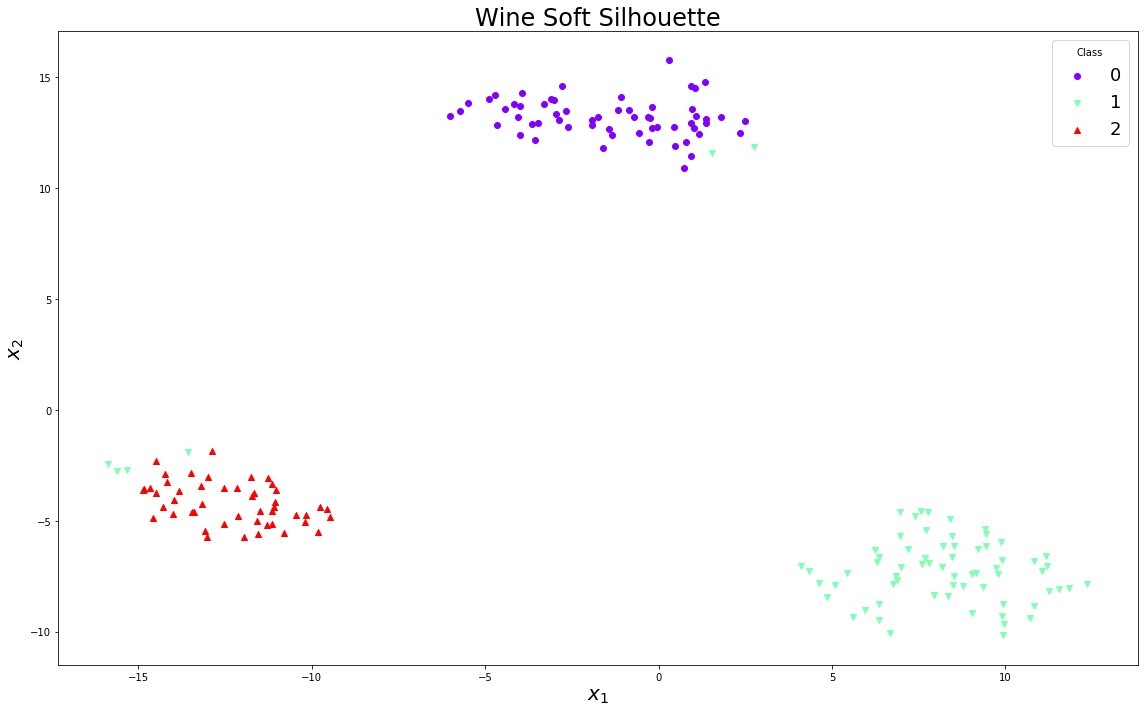

In [6]:
# Cluster with TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_enc = tsne.fit_transform(latent_data)
#tsne_enc = tsne.fit_transform(real_data)

# Color and marker for each true class
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
markers = matplotlib.markers.MarkerStyle.filled_markers

# Save TSNE figure to file
fig, ax = plt.subplots(figsize=(16, 10))
for iclass in range(0, n_clusters):
    # Get indices for each class
    idxs = real_labels==iclass
    # Scatter those points in tsne dims
    ax.scatter(tsne_enc[idxs, 0], tsne_enc[idxs, 1],
               marker=markers[iclass], c=colors[iclass].reshape(1,-1),
               edgecolor=None, label=r'$%i$'%iclass)
    
figname="Wine Soft Silhouette"
ax.set_title(figname, fontsize=24)
ax.set_xlabel("$x_{1}$", fontsize=20)
ax.set_ylabel("$x_{2}$", fontsize=20)
plt.legend(title="Class", loc='best', numpoints=1, fontsize=18)
plt.tight_layout()
plt.show()
#fig.savefig(figname, facecolor='w')